# ConvVAE16 MNIST Training & Testing

This notebook trains and tests the ConvVAE16 model on MNIST dataset for baseline validation.

## 1. Setup & Imports

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from tqdm import tqdm
import json
from datetime import datetime

# Import the ConvVAE16 model
import sys
sys.path.insert(0, os.path.dirname(os.path.abspath('')))
from oadino.models import ConvVAE16

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 2. Data Preparation

In [6]:
# Define transforms
# ConvVAE16 expects 16x16 input, but we can work with resized MNIST
transform = transforms.Compose([
    transforms.Resize((16, 16)),
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel for ConvVAE16
    transforms.ToTensor(),
])

# Download and load MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split train into train and validation
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print(f"Train set: {len(train_dataset)}")
print(f"Validation set: {len(val_dataset)}")
print(f"Test set: {len(test_dataset)}")

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

100%|██████████| 9.91M/9.91M [00:03<00:00, 2.58MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 210kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.15MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.92MB/s]


Train set: 54000
Validation set: 6000
Test set: 10000
Train batches: 844
Validation batches: 94
Test batches: 157


## 3. Model Initialization

In [8]:
# Initialize model
model = ConvVAE16()
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Optimizer
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

print(f"Optimizer: Adam with lr={learning_rate}")

Total parameters: 1,130,115
Trainable parameters: 1,130,115
Optimizer: Adam with lr=0.001


## 4. Loss Functions

In [9]:
def vae_loss(recon_x, x, mean, logvar, beta=1.0):
    """VAE loss = Reconstruction loss + β * KL divergence"""
    # Reconstruction loss (MSE)
    recon_loss = nn.MSELoss(reduction='mean')(recon_x, x)
    
    # KL divergence loss
    # KL(N(mean, var) || N(0, 1)) = 0.5 * sum(mean^2 + var - 1 - log(var))
    kl_loss = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())
    
    total_loss = recon_loss + beta * kl_loss
    return total_loss, recon_loss, kl_loss

print("Loss function defined: VAE loss = MSE + β*KL")

Loss function defined: VAE loss = MSE + β*KL


## 5. Training Loop

In [10]:
def train_epoch(model, train_loader, optimizer, device, beta=1.0):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0
    
    pbar = tqdm(train_loader, desc="Training")
    for images, _ in pbar:
        images = images.to(device)
        
        # Forward pass
        recon_images, mean, logvar = model(images)
        
        # Compute loss
        loss, recon_loss, kl_loss = vae_loss(recon_images, images, mean, logvar, beta=beta)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Accumulate losses
        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()
        
        pbar.set_postfix({
            'loss': loss.item(),
            'recon': recon_loss.item(),
            'kl': kl_loss.item()
        })
    
    avg_loss = total_loss / len(train_loader)
    avg_recon_loss = total_recon_loss / len(train_loader)
    avg_kl_loss = total_kl_loss / len(train_loader)
    
    return avg_loss, avg_recon_loss, avg_kl_loss

print("Training function defined")

Training function defined


## 6. Validation Loop

In [11]:
def validate(model, val_loader, device, beta=1.0):
    """Validate the model"""
    model.eval()
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc="Validating")
        for images, _ in pbar:
            images = images.to(device)
            
            # Forward pass
            recon_images, mean, logvar = model(images)
            
            # Compute loss
            loss, recon_loss, kl_loss = vae_loss(recon_images, images, mean, logvar, beta=beta)
            
            # Accumulate losses
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
            
            pbar.set_postfix({
                'loss': loss.item(),
                'recon': recon_loss.item(),
                'kl': kl_loss.item()
            })
    
    avg_loss = total_loss / len(val_loader)
    avg_recon_loss = total_recon_loss / len(val_loader)
    avg_kl_loss = total_kl_loss / len(val_loader)
    
    return avg_loss, avg_recon_loss, avg_kl_loss

print("Validation function defined")

Validation function defined


## 7. Training Script

In [12]:
# Training parameters
num_epochs = 50
beta = 1.0  # Weight for KL divergence

# Create checkpoint directory
run_name = f"ConvVAE16_MNIST_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
checkpoint_dir = Path(f"runs/{run_name}/checkpoints")
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# Training history
history = {
    'train_loss': [],
    'train_recon_loss': [],
    'train_kl_loss': [],
    'val_loss': [],
    'val_recon_loss': [],
    'val_kl_loss': [],
}

best_val_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'='*60}")
    
    # Train
    train_loss, train_recon, train_kl = train_epoch(model, train_loader, optimizer, device, beta=beta)
    
    # Validate
    val_loss, val_recon, val_kl = validate(model, val_loader, device, beta=beta)
    
    # Record history
    history['train_loss'].append(train_loss)
    history['train_recon_loss'].append(train_recon)
    history['train_kl_loss'].append(train_kl)
    history['val_loss'].append(val_loss)
    history['val_recon_loss'].append(val_recon)
    history['val_kl_loss'].append(val_kl)
    
    # Print results
    print(f"\nTrain Loss: {train_loss:.6f} (Recon: {train_recon:.6f}, KL: {train_kl:.6f})")
    print(f"Val Loss:   {val_loss:.6f} (Recon: {val_recon:.6f}, KL: {val_kl:.6f})")
    
    # Scheduler step
    scheduler.step(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint_path = checkpoint_dir / "best_model.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'history': history,
        }, checkpoint_path)
        print(f"\n✓ Best model saved to {checkpoint_path}")
    
    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint_path = checkpoint_dir / f"checkpoint_epoch_{epoch+1}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'history': history,
        }, checkpoint_path)
        print(f"✓ Checkpoint saved to {checkpoint_path}")

# Save final model
final_path = checkpoint_dir / "final_model.pt"
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
}, final_path)
print(f"\n✓ Final model saved to {final_path}")

# Save training config
config = {
    'latent_base': 64,
    'prior_dim': 32,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'num_epochs': num_epochs,
    'beta': beta,
    'input_size': '16x16',
}
config_path = Path(f"runs/{run_name}") / "config.json"
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)
print(f"✓ Config saved to {config_path}")


Epoch 1/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 13.65it/s, loss=0.0138, recon=0.0105, kl=0.00336] 



Train Loss: 0.023717 (Recon: 0.018095, KL: 0.005622)
Val Loss:   0.014957 (Recon: 0.011195, KL: 0.003762)

✓ Best model saved to runs\ConvVAE16_MNIST_20260213_122001\checkpoints\best_model.pt

Epoch 2/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 13.84it/s, loss=0.0101, recon=0.00747, kl=0.0026]  



Train Loss: 0.010734 (Recon: 0.007378, KL: 0.003356)
Val Loss:   0.010780 (Recon: 0.007732, KL: 0.003048)

✓ Best model saved to runs\ConvVAE16_MNIST_20260213_122001\checkpoints\best_model.pt

Epoch 3/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 13.62it/s, loss=0.00632, recon=0.00494, kl=0.00139]



Train Loss: 0.007157 (Recon: 0.005118, KL: 0.002039)
Val Loss:   0.007118 (Recon: 0.005464, KL: 0.001654)

✓ Best model saved to runs\ConvVAE16_MNIST_20260213_122001\checkpoints\best_model.pt

Epoch 4/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 13.94it/s, loss=0.00318, recon=0.00266, kl=0.000519]



Train Loss: 0.004489 (Recon: 0.003520, KL: 0.000969)
Val Loss:   0.003452 (Recon: 0.002870, KL: 0.000582)

✓ Best model saved to runs\ConvVAE16_MNIST_20260213_122001\checkpoints\best_model.pt

Epoch 5/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 13.73it/s, loss=0.00294, recon=0.00256, kl=0.000376]



Train Loss: 0.003277 (Recon: 0.002752, KL: 0.000525)
Val Loss:   0.003249 (Recon: 0.002837, KL: 0.000412)

✓ Best model saved to runs\ConvVAE16_MNIST_20260213_122001\checkpoints\best_model.pt

Epoch 6/50


Validating: 100%|██████████| 94/94 [00:07<00:00, 12.90it/s, loss=0.00248, recon=0.00219, kl=0.00029] 



Train Loss: 0.002711 (Recon: 0.002341, KL: 0.000370)
Val Loss:   0.002744 (Recon: 0.002432, KL: 0.000312)

✓ Best model saved to runs\ConvVAE16_MNIST_20260213_122001\checkpoints\best_model.pt

Epoch 7/50


Validating: 100%|██████████| 94/94 [00:07<00:00, 12.73it/s, loss=0.00276, recon=0.00247, kl=0.00029] 



Train Loss: 0.002426 (Recon: 0.002120, KL: 0.000306)
Val Loss:   0.002925 (Recon: 0.002620, KL: 0.000305)

Epoch 8/50


Validating: 100%|██████████| 94/94 [00:07<00:00, 13.23it/s, loss=0.00232, recon=0.00211, kl=0.000206]



Train Loss: 0.002236 (Recon: 0.001963, KL: 0.000274)
Val Loss:   0.002429 (Recon: 0.002210, KL: 0.000219)

✓ Best model saved to runs\ConvVAE16_MNIST_20260213_122001\checkpoints\best_model.pt

Epoch 9/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 14.15it/s, loss=0.00201, recon=0.00177, kl=0.000239]



Train Loss: 0.002103 (Recon: 0.001847, KL: 0.000256)
Val Loss:   0.002116 (Recon: 0.001863, KL: 0.000253)

✓ Best model saved to runs\ConvVAE16_MNIST_20260213_122001\checkpoints\best_model.pt

Epoch 10/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 14.05it/s, loss=0.00199, recon=0.00176, kl=0.000222]



Train Loss: 0.001967 (Recon: 0.001727, KL: 0.000239)
Val Loss:   0.002149 (Recon: 0.001913, KL: 0.000236)
✓ Checkpoint saved to runs\ConvVAE16_MNIST_20260213_122001\checkpoints\checkpoint_epoch_10.pt

Epoch 11/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 13.78it/s, loss=0.00163, recon=0.00141, kl=0.000226]



Train Loss: 0.002038 (Recon: 0.001770, KL: 0.000268)
Val Loss:   0.001798 (Recon: 0.001557, KL: 0.000241)

✓ Best model saved to runs\ConvVAE16_MNIST_20260213_122001\checkpoints\best_model.pt

Epoch 12/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 13.85it/s, loss=0.00232, recon=0.00207, kl=0.000255]



Train Loss: 0.001868 (Recon: 0.001627, KL: 0.000241)
Val Loss:   0.002505 (Recon: 0.002236, KL: 0.000269)

Epoch 13/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 13.54it/s, loss=0.00155, recon=0.00134, kl=0.000209]



Train Loss: 0.001805 (Recon: 0.001573, KL: 0.000232)
Val Loss:   0.001658 (Recon: 0.001440, KL: 0.000218)

✓ Best model saved to runs\ConvVAE16_MNIST_20260213_122001\checkpoints\best_model.pt

Epoch 14/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 13.83it/s, loss=0.00177, recon=0.00153, kl=0.000245]



Train Loss: 0.001719 (Recon: 0.001500, KL: 0.000219)
Val Loss:   0.001874 (Recon: 0.001617, KL: 0.000256)

Epoch 15/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 14.39it/s, loss=0.00157, recon=0.00134, kl=0.000225]



Train Loss: 0.001660 (Recon: 0.001447, KL: 0.000213)
Val Loss:   0.001604 (Recon: 0.001369, KL: 0.000235)

✓ Best model saved to runs\ConvVAE16_MNIST_20260213_122001\checkpoints\best_model.pt

Epoch 16/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 14.26it/s, loss=0.00182, recon=0.0016, kl=0.000225] 



Train Loss: 0.001660 (Recon: 0.001441, KL: 0.000220)
Val Loss:   0.001851 (Recon: 0.001616, KL: 0.000236)

Epoch 17/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 13.94it/s, loss=0.00155, recon=0.00136, kl=0.000192]



Train Loss: 0.001546 (Recon: 0.001347, KL: 0.000199)
Val Loss:   0.001630 (Recon: 0.001427, KL: 0.000202)

Epoch 18/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 14.03it/s, loss=0.00162, recon=0.00143, kl=0.00019] 



Train Loss: 0.001504 (Recon: 0.001316, KL: 0.000187)
Val Loss:   0.001751 (Recon: 0.001553, KL: 0.000199)

Epoch 19/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 13.79it/s, loss=0.0013, recon=0.00111, kl=0.000193]  



Train Loss: 0.001437 (Recon: 0.001264, KL: 0.000173)
Val Loss:   0.001408 (Recon: 0.001207, KL: 0.000201)

✓ Best model saved to runs\ConvVAE16_MNIST_20260213_122001\checkpoints\best_model.pt

Epoch 20/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 13.70it/s, loss=0.00217, recon=0.00195, kl=0.000222]



Train Loss: 0.001445 (Recon: 0.001265, KL: 0.000180)
Val Loss:   0.002116 (Recon: 0.001882, KL: 0.000234)
✓ Checkpoint saved to runs\ConvVAE16_MNIST_20260213_122001\checkpoints\checkpoint_epoch_20.pt

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 14.02it/s, loss=0.00177, recon=0.00161, kl=0.000158]



Train Loss: 0.001390 (Recon: 0.001218, KL: 0.000173)
Val Loss:   0.001816 (Recon: 0.001650, KL: 0.000166)

Epoch 22/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 14.06it/s, loss=0.00133, recon=0.00118, kl=0.000147] 



Train Loss: 0.001335 (Recon: 0.001175, KL: 0.000160)
Val Loss:   0.001359 (Recon: 0.001204, KL: 0.000155)

✓ Best model saved to runs\ConvVAE16_MNIST_20260213_122001\checkpoints\best_model.pt

Epoch 23/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 13.90it/s, loss=0.00134, recon=0.0012, kl=0.000139] 



Train Loss: 0.001322 (Recon: 0.001161, KL: 0.000160)
Val Loss:   0.001420 (Recon: 0.001273, KL: 0.000147)

Epoch 24/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 14.25it/s, loss=0.00141, recon=0.00127, kl=0.000136]



Train Loss: 0.001260 (Recon: 0.001113, KL: 0.000147)
Val Loss:   0.001426 (Recon: 0.001284, KL: 0.000142)

Epoch 25/50


Validating: 100%|██████████| 94/94 [00:07<00:00, 13.41it/s, loss=0.00126, recon=0.00112, kl=0.000136] 



Train Loss: 0.001250 (Recon: 0.001102, KL: 0.000148)
Val Loss:   0.001322 (Recon: 0.001179, KL: 0.000143)

✓ Best model saved to runs\ConvVAE16_MNIST_20260213_122001\checkpoints\best_model.pt

Epoch 26/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 13.98it/s, loss=0.00137, recon=0.00122, kl=0.000149]



Train Loss: 0.001228 (Recon: 0.001083, KL: 0.000145)
Val Loss:   0.001401 (Recon: 0.001244, KL: 0.000157)

Epoch 27/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 14.02it/s, loss=0.00124, recon=0.0011, kl=0.00014]   



Train Loss: 0.001193 (Recon: 0.001054, KL: 0.000139)
Val Loss:   0.001308 (Recon: 0.001161, KL: 0.000146)

✓ Best model saved to runs\ConvVAE16_MNIST_20260213_122001\checkpoints\best_model.pt

Epoch 28/50


Validating: 100%|██████████| 94/94 [00:07<00:00, 13.35it/s, loss=0.00135, recon=0.00122, kl=0.000128]



Train Loss: 0.001179 (Recon: 0.001040, KL: 0.000139)
Val Loss:   0.001401 (Recon: 0.001266, KL: 0.000135)

Epoch 29/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 14.13it/s, loss=0.00119, recon=0.00106, kl=0.000133]  



Train Loss: 0.001154 (Recon: 0.001019, KL: 0.000134)
Val Loss:   0.001213 (Recon: 0.001074, KL: 0.000139)

✓ Best model saved to runs\ConvVAE16_MNIST_20260213_122001\checkpoints\best_model.pt

Epoch 30/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 14.21it/s, loss=0.00116, recon=0.00102, kl=0.000138] 



Train Loss: 0.001137 (Recon: 0.001003, KL: 0.000134)
Val Loss:   0.001199 (Recon: 0.001055, KL: 0.000144)

✓ Best model saved to runs\ConvVAE16_MNIST_20260213_122001\checkpoints\best_model.pt
✓ Checkpoint saved to runs\ConvVAE16_MNIST_20260213_122001\checkpoints\checkpoint_epoch_30.pt

Epoch 31/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 14.23it/s, loss=0.00144, recon=0.00131, kl=0.000128]



Train Loss: 0.001119 (Recon: 0.000989, KL: 0.000130)
Val Loss:   0.001502 (Recon: 0.001369, KL: 0.000134)

Epoch 32/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 14.19it/s, loss=0.00115, recon=0.00103, kl=0.00012]  



Train Loss: 0.001111 (Recon: 0.000984, KL: 0.000127)
Val Loss:   0.001189 (Recon: 0.001064, KL: 0.000125)

✓ Best model saved to runs\ConvVAE16_MNIST_20260213_122001\checkpoints\best_model.pt

Epoch 33/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 13.94it/s, loss=0.00114, recon=0.00102, kl=0.000122]  



Train Loss: 0.001095 (Recon: 0.000967, KL: 0.000128)
Val Loss:   0.001202 (Recon: 0.001075, KL: 0.000128)

Epoch 34/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 13.67it/s, loss=0.00127, recon=0.00115, kl=0.000117]



Train Loss: 0.001078 (Recon: 0.000954, KL: 0.000124)
Val Loss:   0.001394 (Recon: 0.001271, KL: 0.000123)

Epoch 35/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 14.28it/s, loss=0.00113, recon=0.00101, kl=0.000119]  



Train Loss: 0.001061 (Recon: 0.000941, KL: 0.000120)
Val Loss:   0.001197 (Recon: 0.001072, KL: 0.000125)

Epoch 36/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 13.89it/s, loss=0.00114, recon=0.00102, kl=0.000118]  



Train Loss: 0.001045 (Recon: 0.000926, KL: 0.000119)
Val Loss:   0.001212 (Recon: 0.001087, KL: 0.000125)

Epoch 37/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 14.16it/s, loss=0.00145, recon=0.00133, kl=0.00012] 



Train Loss: 0.001027 (Recon: 0.000910, KL: 0.000117)
Val Loss:   0.001518 (Recon: 0.001392, KL: 0.000126)

Epoch 38/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 13.64it/s, loss=0.00125, recon=0.00113, kl=0.000117] 



Train Loss: 0.001017 (Recon: 0.000902, KL: 0.000116)
Val Loss:   0.001328 (Recon: 0.001206, KL: 0.000123)

Epoch 39/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 13.97it/s, loss=0.001, recon=0.000924, kl=7.81e-5]   



Train Loss: 0.000818 (Recon: 0.000729, KL: 0.000088)
Val Loss:   0.001022 (Recon: 0.000940, KL: 0.000082)

✓ Best model saved to runs\ConvVAE16_MNIST_20260213_122001\checkpoints\best_model.pt

Epoch 40/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 14.07it/s, loss=0.00091, recon=0.000837, kl=7.31e-5] 



Train Loss: 0.000803 (Recon: 0.000722, KL: 0.000080)
Val Loss:   0.000948 (Recon: 0.000872, KL: 0.000077)

✓ Best model saved to runs\ConvVAE16_MNIST_20260213_122001\checkpoints\best_model.pt
✓ Checkpoint saved to runs\ConvVAE16_MNIST_20260213_122001\checkpoints\checkpoint_epoch_40.pt

Epoch 41/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 13.98it/s, loss=0.000916, recon=0.000843, kl=7.29e-5]



Train Loss: 0.000794 (Recon: 0.000718, KL: 0.000076)
Val Loss:   0.000945 (Recon: 0.000869, KL: 0.000076)

✓ Best model saved to runs\ConvVAE16_MNIST_20260213_122001\checkpoints\best_model.pt

Epoch 42/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 14.05it/s, loss=0.000854, recon=0.000782, kl=7.17e-5]



Train Loss: 0.000782 (Recon: 0.000708, KL: 0.000074)
Val Loss:   0.000885 (Recon: 0.000810, KL: 0.000075)

✓ Best model saved to runs\ConvVAE16_MNIST_20260213_122001\checkpoints\best_model.pt

Epoch 43/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 14.08it/s, loss=0.00084, recon=0.00077, kl=6.98e-5]  



Train Loss: 0.000779 (Recon: 0.000705, KL: 0.000074)
Val Loss:   0.000865 (Recon: 0.000792, KL: 0.000073)

✓ Best model saved to runs\ConvVAE16_MNIST_20260213_122001\checkpoints\best_model.pt

Epoch 44/50


Validating: 100%|██████████| 94/94 [00:07<00:00, 13.38it/s, loss=0.000846, recon=0.000777, kl=6.9e-5] 



Train Loss: 0.000772 (Recon: 0.000699, KL: 0.000073)
Val Loss:   0.000867 (Recon: 0.000794, KL: 0.000073)

Epoch 45/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 13.96it/s, loss=0.000853, recon=0.000782, kl=7.15e-5]



Train Loss: 0.000763 (Recon: 0.000691, KL: 0.000071)
Val Loss:   0.000899 (Recon: 0.000824, KL: 0.000075)

Epoch 46/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 14.43it/s, loss=0.000862, recon=0.000796, kl=6.52e-5]



Train Loss: 0.000759 (Recon: 0.000688, KL: 0.000071)
Val Loss:   0.000886 (Recon: 0.000817, KL: 0.000068)

Epoch 47/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 14.33it/s, loss=0.000915, recon=0.000847, kl=6.82e-5]



Train Loss: 0.000748 (Recon: 0.000679, KL: 0.000070)
Val Loss:   0.000958 (Recon: 0.000886, KL: 0.000071)

Epoch 48/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 14.13it/s, loss=0.000867, recon=0.000801, kl=6.66e-5]



Train Loss: 0.000748 (Recon: 0.000678, KL: 0.000070)
Val Loss:   0.000882 (Recon: 0.000812, KL: 0.000070)

Epoch 49/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 13.67it/s, loss=0.000851, recon=0.000782, kl=6.95e-5]



Train Loss: 0.000741 (Recon: 0.000672, KL: 0.000069)
Val Loss:   0.000867 (Recon: 0.000794, KL: 0.000073)

Epoch 50/50


Validating: 100%|██████████| 94/94 [00:06<00:00, 13.82it/s, loss=0.000746, recon=0.000694, kl=5.23e-5]


Train Loss: 0.000641 (Recon: 0.000582, KL: 0.000060)
Val Loss:   0.000758 (Recon: 0.000703, KL: 0.000055)

✓ Best model saved to runs\ConvVAE16_MNIST_20260213_122001\checkpoints\best_model.pt
✓ Checkpoint saved to runs\ConvVAE16_MNIST_20260213_122001\checkpoints\checkpoint_epoch_50.pt

✓ Final model saved to runs\ConvVAE16_MNIST_20260213_122001\checkpoints\final_model.pt
✓ Config saved to runs\ConvVAE16_MNIST_20260213_122001\config.json


## 8. Plot Training History

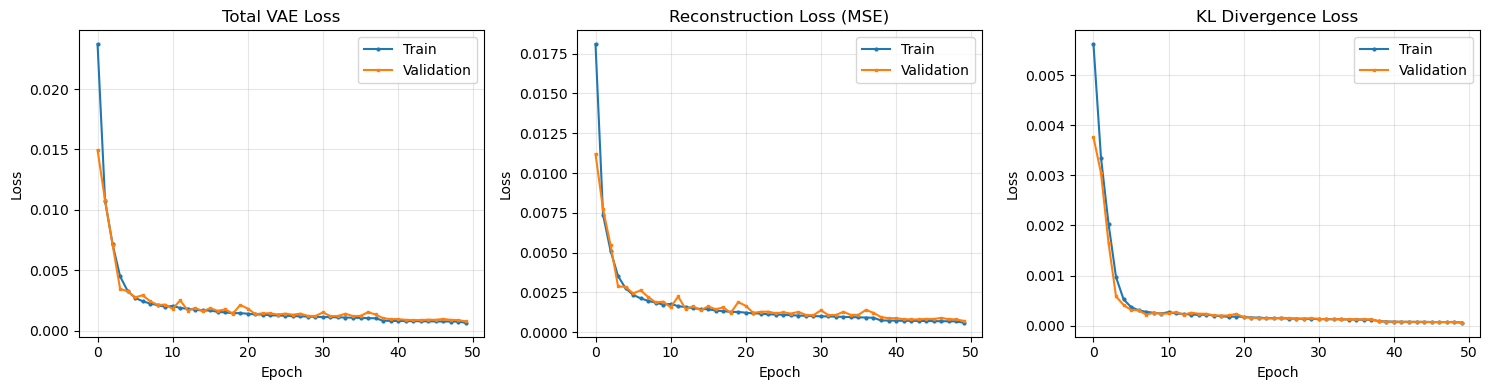

Training history plot saved to runs/ConvVAE16_MNIST_20260213_122001/training_history.png


In [13]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Total loss
axes[0].plot(history['train_loss'], label='Train', marker='o', markersize=2)
axes[0].plot(history['val_loss'], label='Validation', marker='s', markersize=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Total VAE Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Reconstruction loss
axes[1].plot(history['train_recon_loss'], label='Train', marker='o', markersize=2)
axes[1].plot(history['val_recon_loss'], label='Validation', marker='s', markersize=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Reconstruction Loss (MSE)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# KL loss
axes[2].plot(history['train_kl_loss'], label='Train', marker='o', markersize=2)
axes[2].plot(history['val_kl_loss'], label='Validation', marker='s', markersize=2)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].set_title('KL Divergence Loss')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"runs/{run_name}/training_history.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Training history plot saved to runs/{run_name}/training_history.png")

## 9. Test Evaluation

In [14]:
# Load best model
best_checkpoint = torch.load(checkpoint_dir / "best_model.pt", map_location=device, weights_only=False)
model.load_state_dict(best_checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {best_checkpoint['epoch']}")

# Evaluate on test set
test_loss, test_recon, test_kl = validate(model, test_loader, device, beta=beta)
print(f"\nTest Loss: {test_loss:.6f} (Recon: {test_recon:.6f}, KL: {test_kl:.6f})")

Loaded best model from epoch 49


Validating: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s, loss=0.000711, recon=0.000651, kl=6.09e-5]


Test Loss: 0.000737 (Recon: 0.000682, KL: 0.000055)


## 10. Reconstruction Visualization

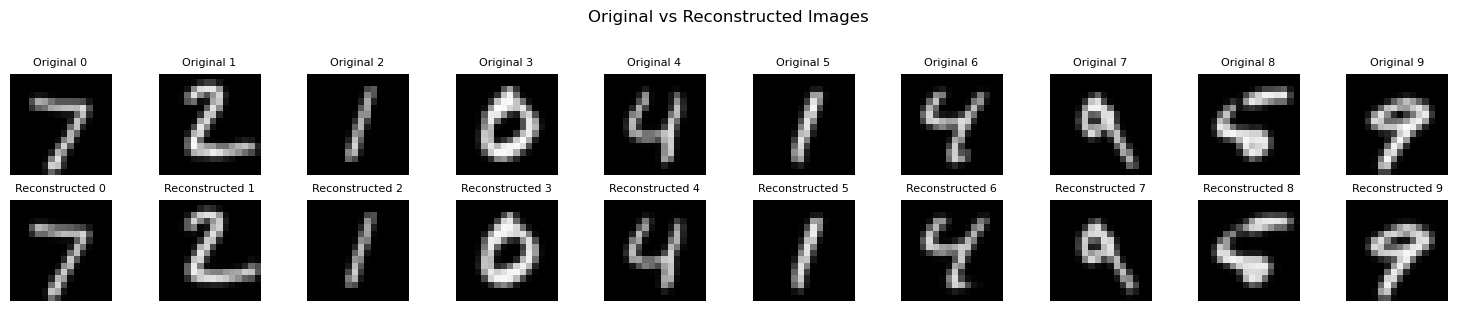

Reconstruction visualization saved to runs/ConvVAE16_MNIST_20260213_122001/reconstructions.png


In [15]:
# Get a batch for visualization
model.eval()
with torch.no_grad():
    test_images, _ = next(iter(test_loader))
    test_images = test_images.to(device)
    recon_images, _, _ = model(test_images)
    
    # Move to CPU for visualization
    test_images = test_images.cpu()
    recon_images = recon_images.cpu()

# Visualize original vs reconstructed
n_samples = 10
fig, axes = plt.subplots(2, n_samples, figsize=(15, 3))

for i in range(n_samples):
    # Original
    orig = test_images[i].permute(1, 2, 0).numpy()
    orig = np.clip(orig, 0, 1)
    axes[0, i].imshow(orig, cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Original {i}', fontsize=8)
    
    # Reconstructed
    recon = recon_images[i].permute(1, 2, 0).numpy()
    recon = np.clip(recon, 0, 1)
    axes[1, i].imshow(recon, cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Reconstructed {i}', fontsize=8)

plt.suptitle('Original vs Reconstructed Images', fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig(f"runs/{run_name}/reconstructions.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Reconstruction visualization saved to runs/{run_name}/reconstructions.png")